### Getting basic requirements and installations out of the way

In [1]:
import torch
import torch.nn as nn
import torchvision

import os
import sys
import time
import random

import numpy as np
import pandas as pd
from scipy import linalg
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.nn.functional import adaptive_avg_pool2d
from torch.utils.data import Subset

import torchvision
from torchvision import datasets, transforms, models, utils
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, Dataset
from itertools import cycle
from tqdm import tqdm
import numpy as np

import copy

### Utils

In [2]:
classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(num_classes=num_classes):
    backbone = torchvision.models.resnet50(weights="IMAGENET1K_V2")
    backbone.fc = nn.Identity()
    

    for param in backbone.parameters():
        param.requires_grad = False

    for param in backbone.layer3.parameters():
        param.requires_grad = True
    for param in backbone.layer4.parameters():
        param.requires_grad = True

    for module in backbone.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()
            for param in module.parameters():
                param.requires_grad = False

    classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(2048, num_classes)
    )

    return backbone, classifier


def make_dataloaders(data_path, batch_size=32, train_ratio=0.8, seed=42):
    '''
    A helper function that ensures data augmentation only in train, with a determinisitic test dataset for eval
    Since we are using pretrained Resnet50, the transforms are the same as for ImageNet 
    '''
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])

    full_dataset = datasets.ImageFolder(root=data_path)
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def train_one_epoch(model, dataloader, optimizer, criterion, device=device, pseudo_lambda=1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training", leave=True):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) * pseudo_lambda
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = 100 * correct / total
    return avg_loss, acc

def plot_training_log(log):
    epochs = range(1, len(log["train_loss"]) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, log["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, log["test_loss"], label="Test Loss", marker='s')
    plt.title("Training and Test Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, log["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, log["test_acc"], label="Test Accuracy", marker='s')
    plt.title("Training and Test Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

def show_preds(model, dataloader, show_misclassified=False, num_images=16):
    model.eval()

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    if show_misclassified:
        idx = (preds != labels).nonzero(as_tuple=True)[0]
    else:
        idx = (preds == labels).nonzero(as_tuple=True)[0]

    images = images[idx]
    labels = labels[idx]
    preds = preds[idx]

    num_show = min(num_images, images.size(0))
    if num_show == 0:
        print("No images to show for this category (check show_misclassified flag).")
        return

    mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    ncols = 4
    nrows = (num_show + ncols - 1) // ncols

    plt.figure(figsize=(ncols * 3, nrows * 3))
    for i in range(num_show):
        img = images[i].permute(1, 2, 0) * std + mean
        img = torch.clamp(img, 0, 1).cpu().numpy()

        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(
            f"Pred: {classes[preds[i].item()]}\nTrue: {classes[labels[i].item()]}",
            fontsize=9
        )
        plt.axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()


def plot_confusion_matrix(model, dataloader, class_names=classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    return cm

art_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/art_painting"
cartoon_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/cartoon"
photo_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/photo"
sketch_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/sketch"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# art_train_loader, art_test_loader = make_dataloaders(art_path)
cartoon_train_loader, cartoon_test_loader = make_dataloaders(cartoon_path)
# photo_train_loader, photo_test_loader = make_dataloaders(photo_path)
sketch_train_loader, sketch_test_loader = make_dataloaders(sketch_path)

for images, labels in cartoon_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in sketch_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_source_target(feature_extractor, source_loader, target_loader, title="", class_names=classes):
    """
    Plots t-SNE of features from a ResNet-50 feature extractor for source and target domains.
    
    Args:
        feature_extractor: ResNet50 with final layer removed or replaced (outputs 2048-dim)
        source_loader: DataLoader for source domain
        target_loader: DataLoader for target domain
        class_names: list of class names corresponding to label indices
        device: 'cuda' or 'cpu'
    """
    feature_extractor.eval()
    feature_extractor.to(device)
    
    all_features = []
    all_labels = []
    all_markers = []  # 0 = source, 1 = target
    
    # Helper to collect features
    def extract_features(dataloader, marker):
        features_list, labels_list = [], []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                features_list.append(features.cpu())
                labels_list.append(labels.cpu())
        all_features.append(torch.cat(features_list, dim=0))
        all_labels.append(torch.cat(labels_list, dim=0))
        all_markers.append(torch.full((len(labels_list[0]) * len(labels_list),), marker))
    
    # Extract features from source and target
    extract_features(source_loader, marker=0)
    extract_features(target_loader, marker=1)
    
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_markers = torch.cat(all_markers, dim=0).numpy()
    
    # t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features)
    
    # Plot
    plt.figure(figsize=(10,10))
    num_classes = len(class_names)
    cmap = plt.get_cmap('tab10')
    
    markers = ['o', 'x']  # circle for source, x for target
    for idx, class_name in enumerate(class_names):
        for marker_type in [0, 1]:  # source, target
            indices = np.where((all_labels == idx) & (all_markers == marker_type))
            plt.scatter(features_2d[indices, 0], features_2d[indices, 1],
                        label=f"{class_name} {'source' if marker_type==0 else 'target'}",
                        alpha=0.7, color=cmap(idx % 10), marker=markers[marker_type])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

Art batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
Art batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


### creating all datasets

In [3]:
art_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/art_painting"
cartoon_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/cartoon"
photo_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/photo"
sketch_path = "/kaggle/input/pacs-dataset/Homework3-PACS-master/PACS/sketch"

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# art_train_loader, art_test_loader = make_dataloaders(art_path)
cartoon_train_loader, cartoon_test_loader = make_dataloaders(cartoon_path)
# photo_train_loader, photo_test_loader = make_dataloaders(photo_path)
sketch_train_loader, sketch_test_loader = make_dataloaders(sketch_path)

for images, labels in cartoon_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

for images, labels in sketch_train_loader:
    print(f"Art batch: {images.shape}, Labels: {labels.shape}")
    break

Art batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
Art batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


In [4]:
def plot_tsne(feature_extractor, source_loader, target_loader, title="", class_names=classes):
    """
    Plots t-SNE of features from a ResNet-50 feature extractor for source and target domains.
    
    Args:
        feature_extractor: ResNet50 with final layer removed or replaced (outputs 2048-dim)
        source_loader: DataLoader for source domain
        target_loader: DataLoader for target domain
        class_names: list of class names corresponding to label indices
        device: 'cuda' or 'cpu'
    """
    feature_extractor.eval()
    feature_extractor.to(device)
    
    all_features = []
    all_labels = []
    all_markers = []  # 0 = source, 1 = target
    
    # Helper to collect features
    def extract_features(dataloader, marker):
        features_list, labels_list = [], []
        markers_list = []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                features = feature_extractor(images)
                features = features.view(features.size(0), -1)
                features_list.append(features.cpu())
                labels_list.append(labels.cpu())
                markers_list.append(torch.full((labels.size(0),), marker))
        all_features.append(torch.cat(features_list, dim=0))
        all_labels.append(torch.cat(labels_list, dim=0))
        all_markers.append(torch.cat(markers_list, dim=0))

    
    # Extract features from source and target
    extract_features(source_loader, marker=0)
    extract_features(target_loader, marker=1)
    
    all_features = torch.cat(all_features, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_markers = torch.cat(all_markers, dim=0).numpy()
    
    # t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features)
    
    # Plot
    plt.figure(figsize=(10,10))
    num_classes = len(class_names)
    cmap = plt.get_cmap('tab10')
    
    markers = ['o', 'x']  # circle for source, x for target
    for idx, class_name in enumerate(class_names):
        for marker_type in [0, 1]:  # source, target
            indices = np.where((all_labels == idx) & (all_markers == marker_type))
            plt.scatter(features_2d[indices, 0], features_2d[indices, 1],
                        label=f"{class_name} {'source' if marker_type==0 else 'target'}",
                        alpha=0.7, color=cmap(idx % 10), marker=markers[marker_type])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

## We are choosing Cartoon as source domain and Sketch as Target domain

# Task 1

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torchvision import models
from tqdm import tqdm
import torch.nn.functional as F

# -----------------------------
# Gradient Reversal Layer
# -----------------------------
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha):
    return GradReverse.apply(x, alpha)

# -----------------------------
# Feature Extractor (ResNet-50)
# -----------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, freeze_layers=True):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.out_features = 2048

        if freeze_layers:
            # Freeze first conv + layer1
            for param in self.backbone[0].parameters():  # conv1
                param.requires_grad = False
            for param in self.backbone[4].parameters():  # layer1
                param.requires_grad = False
            # Freeze all BatchNorm layers
            for m in self.backbone.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.eval()
                    for param in m.parameters():
                        param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        return x

# -----------------------------
# Label Classifier
# -----------------------------
class LabelClassifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)

# -----------------------------
# Conditional Domain Classifier
# -----------------------------
class CDANNDomainClassifier(nn.Module):
    def __init__(self, feature_dim=2048, num_classes=7):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # 2 domains: source/target
        )
    
    def forward(self, features, labels_one_hot, alpha):
        x = grad_reverse(features, alpha)
        x = torch.cat([x, labels_one_hot], dim=1)
        return self.fc(x)

# -----------------------------
# CDANN Training Loop
# -----------------------------
def train_cdann(feature_extractor, label_classifier, domain_classifier,
                source_loader, target_loader, device, num_epochs=20,
                lr=1e-4, lambda_domain=0.1):
    model = nn.Sequential(feature_extractor, label_classifier)
    feature_extractor.to(device)
    label_classifier.to(device)
    domain_classifier.to(device)
    
    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                           list(label_classifier.parameters()) +
                           list(domain_classifier.parameters()), lr=lr)
    
    criterion_class = nn.CrossEntropyLoss()
    criterion_domain = nn.CrossEntropyLoss()
    
    num_classes = 7  # PACS
    
    for epoch in range(num_epochs):
        feature_extractor.train()
        label_classifier.train()
        domain_classifier.train()
        
        total_loss = 0
        total_class_loss = 0
        total_domain_loss = 0
        
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)
        num_batches = min(len(source_loader), len(target_loader))

        best_loss = 0
        
        for _ in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # ---------------------
            # Load batches
            # ---------------------
            try:
                source_data, source_labels = next(source_iter)
            except StopIteration:
                source_iter = iter(source_loader)
                source_data, source_labels = next(source_iter)
            
            try:
                target_data, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                target_data, _ = next(target_iter)
            
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data = target_data.to(device)
            
            # ---------------------
            # Forward pass: source
            # ---------------------
            source_features = feature_extractor(source_data)
            class_preds = label_classifier(source_features)
            class_loss = criterion_class(class_preds, source_labels)
            
            # One-hot labels for domain classifier
            source_labels_one_hot = F.one_hot(source_labels, num_classes=num_classes).float()
            
            # ---------------------
            # Forward pass: target
            # ---------------------
            target_features = feature_extractor(target_data)
            # Use predicted soft labels
            with torch.no_grad():
                target_class_preds = label_classifier(target_features)
                target_labels_soft = F.softmax(target_class_preds, dim=1)
            
            # ---------------------
            # Domain loss
            # ---------------------
            all_features = torch.cat([source_features, target_features], dim=0)
            all_labels = torch.cat([source_labels_one_hot, target_labels_soft], dim=0)
            
            p = epoch / num_epochs
            p_tensor = torch.tensor(p, device=device, dtype=torch.float32)
            alpha = 2. / (1. + torch.exp(-10 * p_tensor)) - 1
            alpha *= 0.1

            
            
            domain_preds = domain_classifier(all_features, all_labels, alpha)
            domain_labels = torch.cat([
                torch.zeros(source_data.size(0), dtype=torch.long),
                torch.ones(target_data.size(0), dtype=torch.long)
            ], dim=0).to(device)
            domain_loss = criterion_domain(domain_preds, domain_labels)
            
            # ---------------------
            # Total loss
            # ---------------------
            loss = class_loss + lambda_domain * domain_loss
            
            # ---------------------
            # Backward
            # ---------------------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_domain_loss += domain_loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Total Loss: {total_loss/num_batches:.4f} | "
              f"Class Loss: {total_class_loss/num_batches:.4f} | Domain Loss: {total_domain_loss/num_batches:.4f}")

        target_test_loss, og_target_test = evaluate(model, sketch_test_loader, nn.CrossEntropyLoss(), device)
        print(f"Target Domain Accuracy: {og_target_test:.2f}%")
        target_test_loss, og_target_test_acc = evaluate(model, cartoon_test_loader, nn.CrossEntropyLoss(), device)
        print(f"Source Domain Accuracy: {og_target_test_acc:.2f}%")

        if best_loss < og_target_test:
            best_loss = og_target_test
            torch.save(model.state_dict(), "/kaggle/working/cdann.pth")
            print("new best model saved")
        
        torch.cuda.empty_cache()  # avoid fragmentation


In [6]:
# -----------------------------
# Example Usage
# -----------------------------

source_loader = cartoon_train_loader
target_loader = sketch_train_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = FeatureExtractor()
label_classifier = LabelClassifier(num_classes=7)
domain_classifier = CDANNDomainClassifier()
train_cdann(feature_extractor, label_classifier, domain_classifier,
           source_loader, target_loader, device, num_epochs=20)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]
Epoch 1/20: 100%|██████████| 59/59 [00:22<00:00,  2.57it/s]


Epoch 1/20 | Total Loss: 0.7545 | Class Loss: 0.6960 | Domain Loss: 0.5843


Target Domain Accuracy: 60.31%


Source Domain Accuracy: 92.32%
new best model saved


Epoch 2/20: 100%|██████████| 59/59 [00:17<00:00,  3.43it/s]


Epoch 2/20 | Total Loss: 0.1580 | Class Loss: 0.1235 | Domain Loss: 0.3442


Target Domain Accuracy: 39.82%


Source Domain Accuracy: 92.75%
new best model saved


Epoch 3/20: 100%|██████████| 59/59 [00:17<00:00,  3.45it/s]


Epoch 3/20 | Total Loss: 0.0698 | Class Loss: 0.0452 | Domain Loss: 0.2464


Target Domain Accuracy: 54.71%


Source Domain Accuracy: 90.62%
new best model saved


Epoch 4/20: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch 4/20 | Total Loss: 0.0519 | Class Loss: 0.0309 | Domain Loss: 0.2093


Target Domain Accuracy: 64.89%


Source Domain Accuracy: 94.46%
new best model saved


Epoch 5/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 5/20 | Total Loss: 0.0578 | Class Loss: 0.0379 | Domain Loss: 0.1980


Target Domain Accuracy: 56.36%


Source Domain Accuracy: 92.75%
new best model saved


Epoch 6/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 6/20 | Total Loss: 0.0361 | Class Loss: 0.0176 | Domain Loss: 0.1852


Target Domain Accuracy: 57.63%


Source Domain Accuracy: 92.32%
new best model saved


Epoch 7/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 7/20 | Total Loss: 0.0335 | Class Loss: 0.0124 | Domain Loss: 0.2110


Target Domain Accuracy: 59.67%


Source Domain Accuracy: 92.32%
new best model saved


Epoch 8/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 8/20 | Total Loss: 0.0581 | Class Loss: 0.0346 | Domain Loss: 0.2348


Target Domain Accuracy: 54.45%


Source Domain Accuracy: 92.75%
new best model saved


Epoch 9/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 9/20 | Total Loss: 0.0719 | Class Loss: 0.0464 | Domain Loss: 0.2551


Target Domain Accuracy: 45.42%


Source Domain Accuracy: 89.98%
new best model saved


Epoch 10/20: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch 10/20 | Total Loss: 0.0943 | Class Loss: 0.0641 | Domain Loss: 0.3027


Target Domain Accuracy: 51.65%


Source Domain Accuracy: 91.26%
new best model saved


Epoch 11/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 11/20 | Total Loss: 0.0764 | Class Loss: 0.0423 | Domain Loss: 0.3413


Target Domain Accuracy: 58.52%


Source Domain Accuracy: 94.24%
new best model saved


Epoch 12/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 12/20 | Total Loss: 0.0673 | Class Loss: 0.0268 | Domain Loss: 0.4046


Target Domain Accuracy: 52.42%


Source Domain Accuracy: 94.03%
new best model saved


Epoch 13/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 13/20 | Total Loss: 0.0564 | Class Loss: 0.0135 | Domain Loss: 0.4287


Target Domain Accuracy: 57.51%


Source Domain Accuracy: 93.60%
new best model saved


Epoch 14/20: 100%|██████████| 59/59 [00:16<00:00,  3.48it/s]


Epoch 14/20 | Total Loss: 0.0524 | Class Loss: 0.0089 | Domain Loss: 0.4353


Target Domain Accuracy: 54.20%


Source Domain Accuracy: 92.96%
new best model saved


Epoch 15/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 15/20 | Total Loss: 0.0470 | Class Loss: 0.0048 | Domain Loss: 0.4219


Target Domain Accuracy: 61.45%


Source Domain Accuracy: 93.18%
new best model saved


Epoch 16/20: 100%|██████████| 59/59 [00:16<00:00,  3.49it/s]


Epoch 16/20 | Total Loss: 0.0506 | Class Loss: 0.0088 | Domain Loss: 0.4180


Target Domain Accuracy: 66.79%


Source Domain Accuracy: 93.39%
new best model saved


Epoch 17/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 17/20 | Total Loss: 0.0462 | Class Loss: 0.0058 | Domain Loss: 0.4044


Target Domain Accuracy: 64.38%


Source Domain Accuracy: 92.32%
new best model saved


Epoch 18/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 18/20 | Total Loss: 0.0575 | Class Loss: 0.0177 | Domain Loss: 0.3989


Target Domain Accuracy: 62.98%


Source Domain Accuracy: 93.18%
new best model saved


Epoch 19/20: 100%|██████████| 59/59 [00:17<00:00,  3.47it/s]


Epoch 19/20 | Total Loss: 0.0684 | Class Loss: 0.0260 | Domain Loss: 0.4240


Target Domain Accuracy: 62.34%


Source Domain Accuracy: 93.60%
new best model saved


Epoch 20/20: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Epoch 20/20 | Total Loss: 0.0584 | Class Loss: 0.0181 | Domain Loss: 0.4027


Target Domain Accuracy: 65.39%


Source Domain Accuracy: 94.88%
new best model saved


### Creating the model

In [7]:
model = nn.Sequential(feature_extractor, label_classifier)
model.load_state_dict(torch.load("/kaggle/working/cdann.pth"))

<All keys matched successfully>

In [8]:
# backbone, classifier = get_model()
# model = nn.Sequential(backbone, classifier)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam([
#     {'params': backbone.parameters(), 'lr': 1e-5},
#     {'params': classifier.parameters(), 'lr': 1e-4}
# ], weight_decay=1e-4)

In [9]:
# num_epochs = 20

# training_log = {
#     "train_loss" : [],
#     "train_acc" : [],
#     "test_loss" : [],
#     "test_acc" : []
# }

# best_test = 0

# for epoch in range(num_epochs):

#     train_loss, train_acc = train_one_epoch(model, cartoon_train_loader, optimizer, criterion, device)
#     test_loss, test_acc = evaluate(model, cartoon_test_loader, criterion, device)

#     training_log["train_loss"].append(train_loss)
#     training_log["train_acc"].append(train_acc)
#     training_log["test_loss"].append(test_loss)
#     training_log["test_acc"].append(test_acc)

#     print(f"--------------- Epoch [{epoch+1}/{num_epochs}] ---------------")
#     print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
#     print(f"  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2f}%\n")

#     if best_test < test_acc:
#         torch.save(model.state_dict(), "/kaggle/working/source_domain_cartoon_weights.pth")
#         best_test = test_acc
#         print("Best model updated")

# plot_training_log(training_log)

Source Domain Accuracy: 94.88%


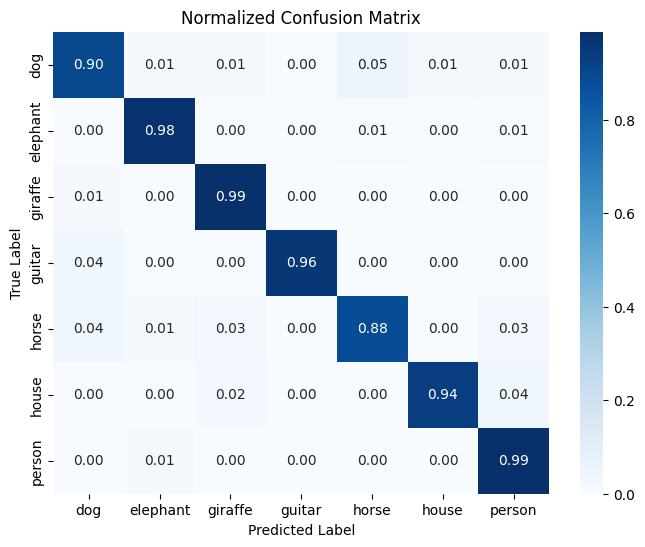

array([[71,  1,  1,  0,  4,  1,  1],
       [ 0, 90,  0,  0,  1,  0,  1],
       [ 1,  0, 71,  0,  0,  0,  0],
       [ 1,  0,  0, 24,  0,  0,  0],
       [ 3,  1,  2,  0, 60,  0,  2],
       [ 0,  0,  1,  0,  0, 45,  2],
       [ 0,  1,  0,  0,  0,  0, 84]])

In [10]:
target_test_loss, og_target_test_acc = evaluate(model, cartoon_test_loader, nn.CrossEntropyLoss(), device)
print(f"Source Domain Accuracy: {og_target_test_acc:.2f}%")

plot_confusion_matrix(model, cartoon_test_loader)

### Most noticeable confusion is between horse and dog, but that's about the only big one.

### Images it has classified correctly

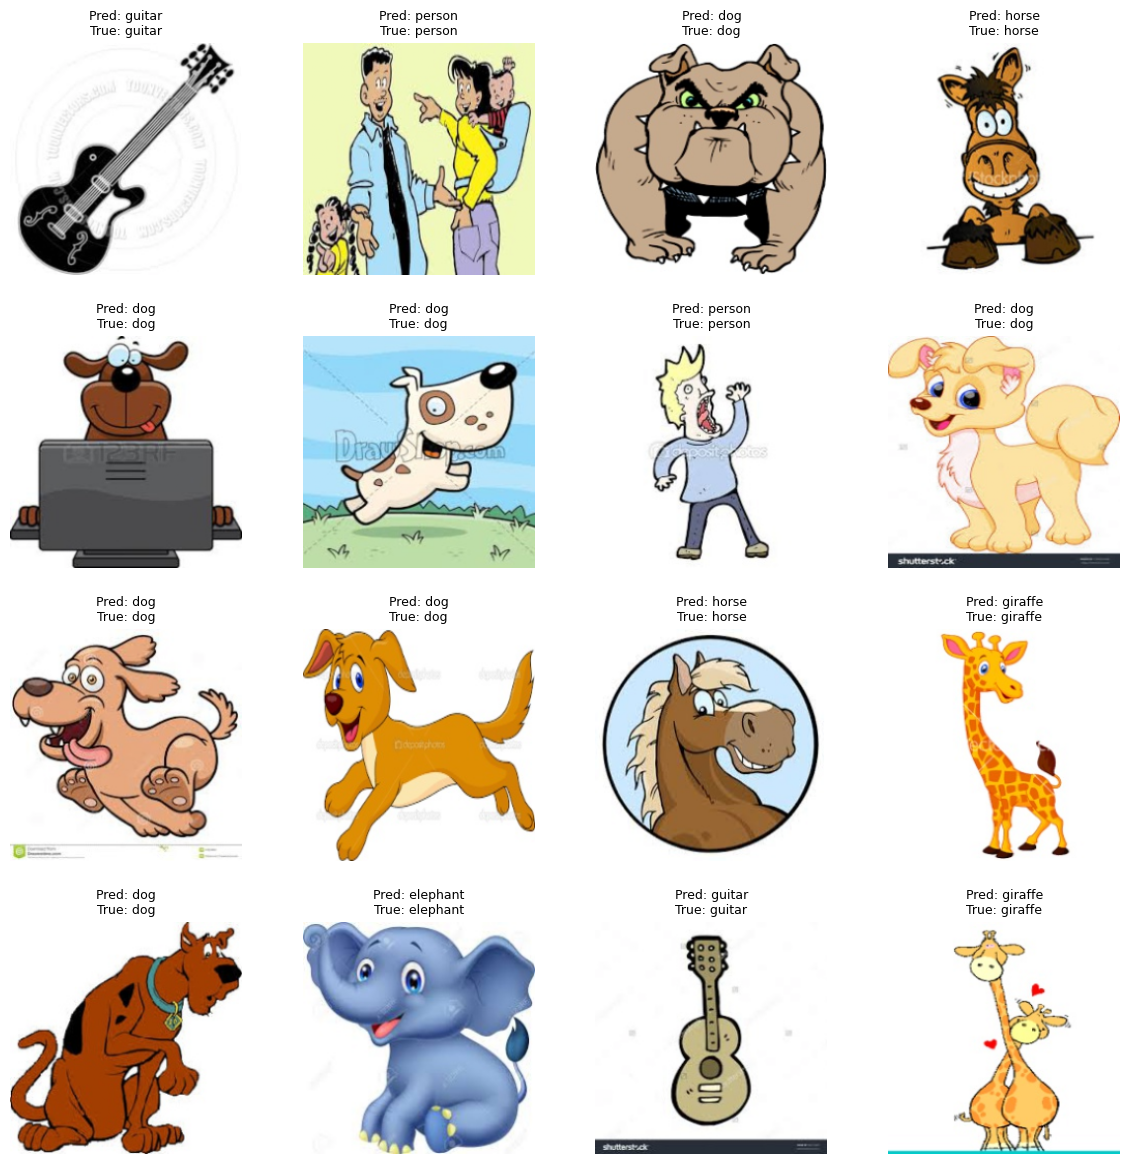

In [11]:
show_preds(model, cartoon_test_loader, show_misclassified=False)

### Images it has classified Incorrectly

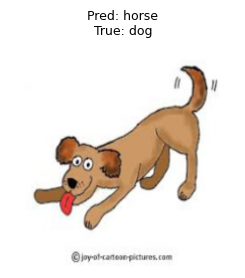

In [12]:
show_preds(model, cartoon_test_loader, show_misclassified=True)

# Now testing on target domain

Target Domain Accuracy: 65.39%


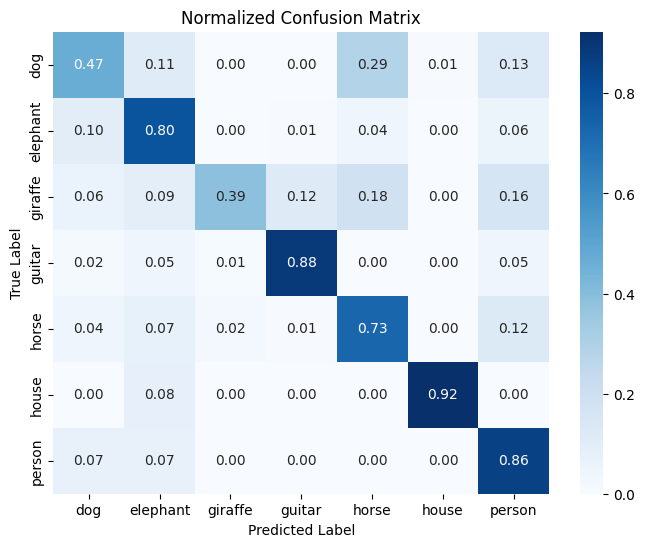

array([[ 70,  17,   0,   0,  43,   1,  19],
       [ 14, 113,   0,   1,   6,   0,   8],
       [ 10,  15,  63,  19,  30,   0,  26],
       [  2,   6,   1, 114,   0,   0,   6],
       [  7,  12,   3,   1, 117,   0,  20],
       [  0,   1,   0,   0,   0,  12,   0],
       [  2,   2,   0,   0,   0,   0,  25]])

In [13]:
target_test_loss, og_target_test_acc = evaluate(model, sketch_test_loader, nn.CrossEntropyLoss(), device)
print(f"Target Domain Accuracy: {og_target_test_acc:.2f}%")

plot_confusion_matrix(model, sketch_test_loader)

### images it has correctly classified

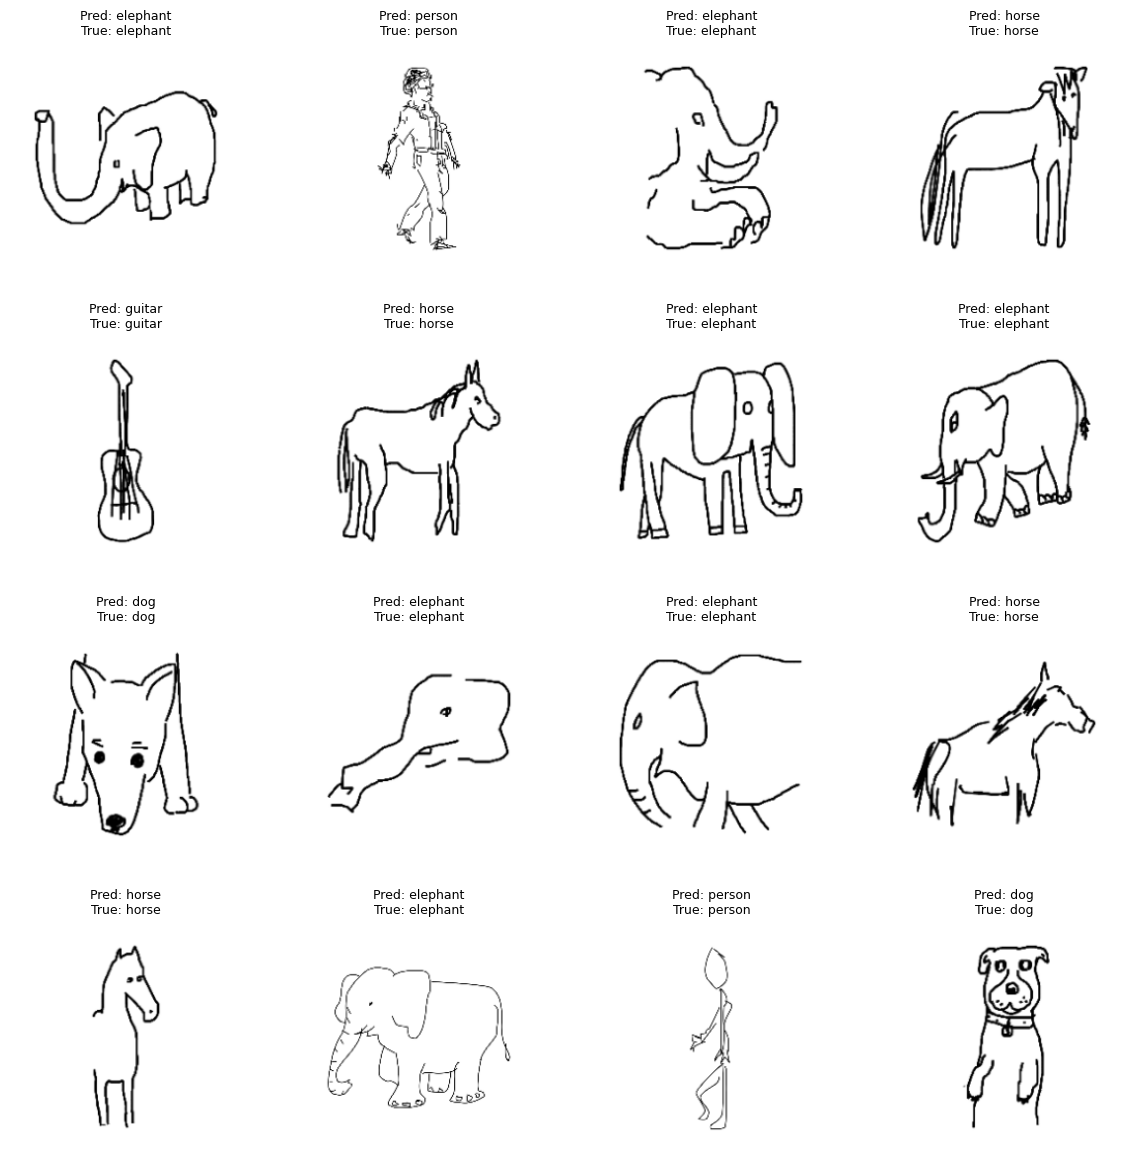

In [14]:
show_preds(model, sketch_test_loader, show_misclassified=False)

### images it has incorrectly classified

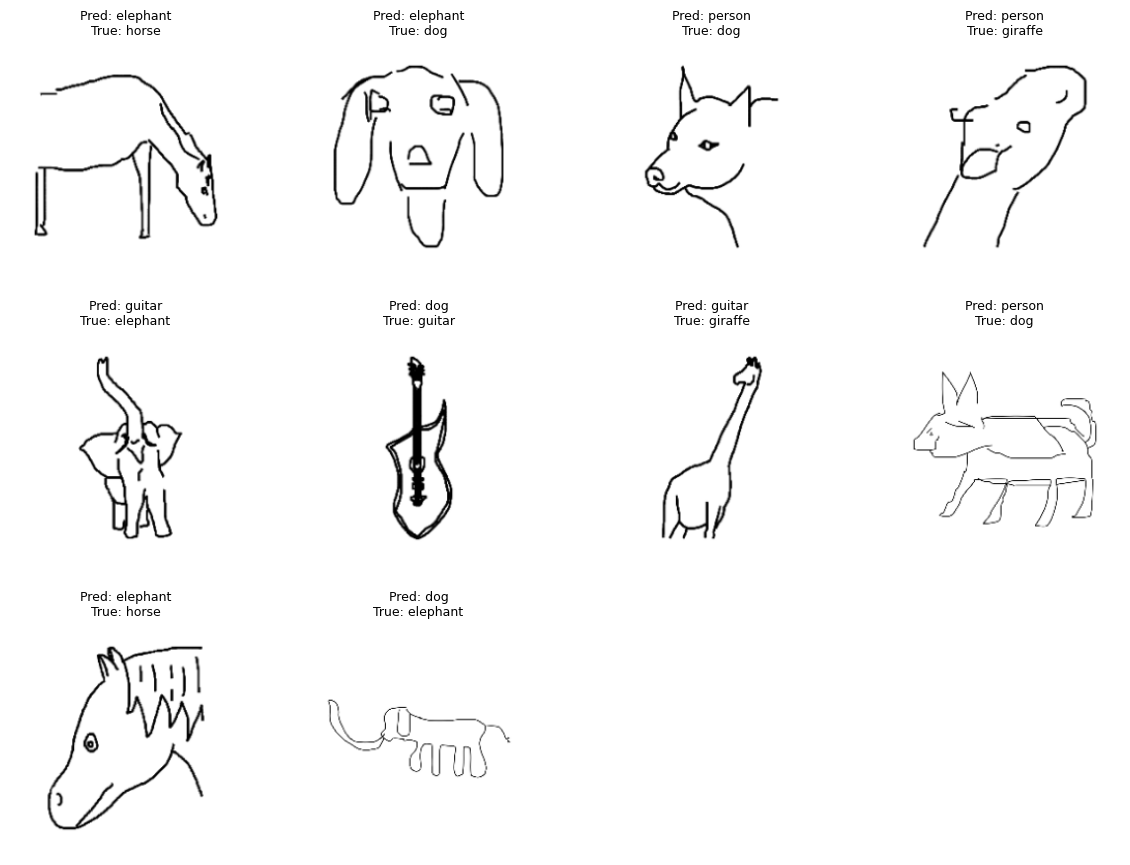

In [15]:
show_preds(model, sketch_test_loader, show_misclassified=True)

In [16]:
source_test_loss, source_test_acc = evaluate(adapt_model, cartoon_test_loader, criterion, device)
print(f"Source Domain Accuracy: {source_test_acc:.2f}%, from originally {best_test:.2f}%")

plot_confusion_matrix(model, cartoon_test_loader)

NameError: name 'adapt_model' is not defined

In [ ]:
target_test_loss, target_test_acc = evaluate(adapt_model, sketch_test_loader, criterion, device)
print(f"Target Domain Accuracy: {target_test_acc:.2f}%, from originally {og_target_test_acc:.2f}%")

plot_confusion_matrix(model, sketch_test_loader)

In [ ]:
show_preds(model, sketch_test_loader, show_misclassified=False)

In [ ]:
show_preds(model, sketch_test_loader, show_misclassified=True)

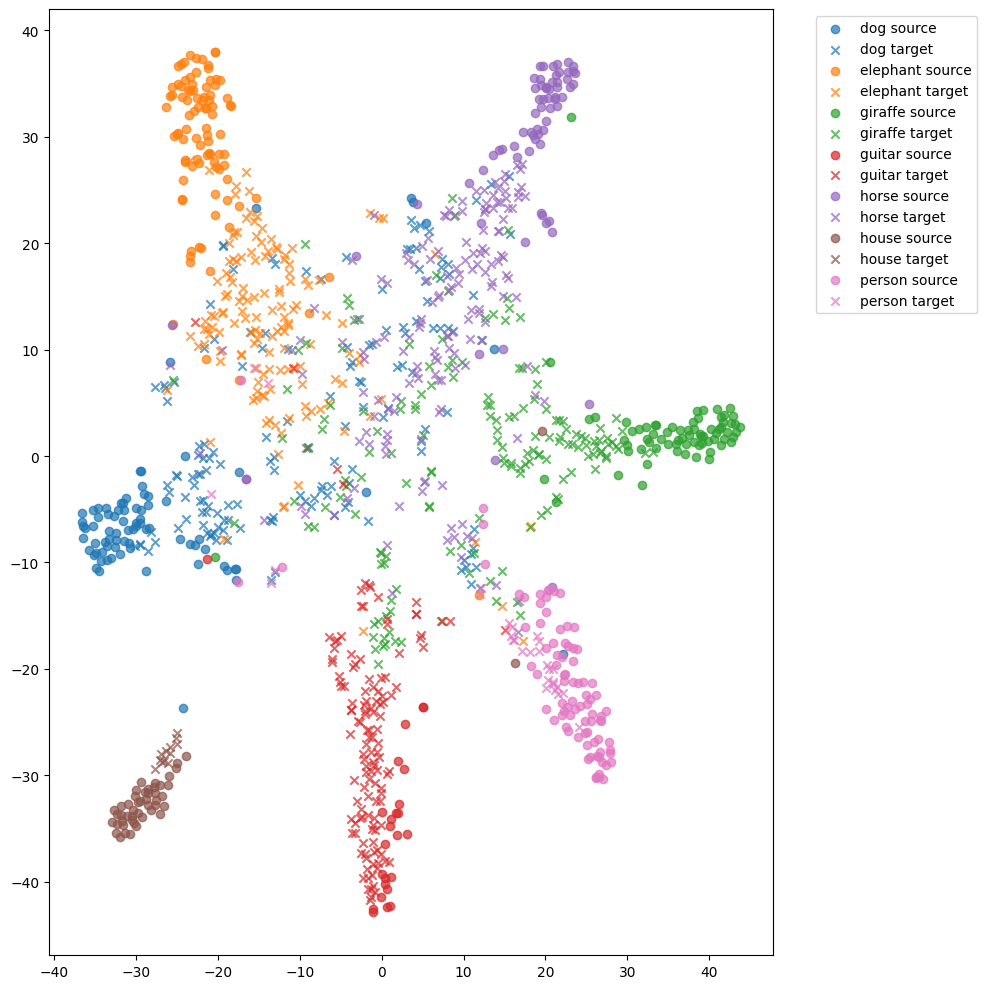

In [17]:
plot_tsne(feature_extractor, cartoon_test_loader, sketch_test_loader, class_names=classes)